# Predictive Maintenance of NASA Turbofan Engine

##### In this notebook, we build an Decision Tree Classification Model to predict remaining useful life of aircraft engines. 
##### In summary, the template uses simulated aircraft sensor values to predict when an aircraft engine will fail in the future so that maintenance can be planned in advance.

<img src="turbofan-engine-nasa.jpeg" alt="Alt text" width="1000">


### Dataset Description

- The dataset consists of sensor readings from a fleet of simulated aircraft gas turbine engines operating conditions as a multiple multivariate time series. The dataset consists of separate training/test sets.

- The testset is similar to the training set, except that each engine’s measurements are truncated some amount of time before it fails, this amount is found in the truth dataset.

- Each row represents a snapshot of data taken during a single operational cycle and each column represents a different variable.

![](features.png)

In [1]:
import pandas as pd
import warnings

# Filter out warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the text file using read_csv()
train_data = pd.read_csv('PM_train.txt', delimiter=' ',index_col=False, header=None)
test_data = pd.read_csv('PM_test.txt',delimiter=' ',index_col=False, header=None)

print('Train data: ',train_data.shape)
print('Test data: ',test_data.shape)

train_data.head()

Train data:  (20631, 28)
Test data:  (11939, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
# List of the ground truth of the test data
# Indicates the remaining useful cycles for an engine
true = [112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28,
        87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19,
        21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26,
        97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94,
        118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89,
        116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]

# Convert the list to a Pandas DataFrame
true_test = pd.DataFrame(true, columns=['Additional RUL'])
print('True test dim: ',true_test.shape)
true_test.head()


True test dim:  (100, 1)


,Additional RUL
0,112
1,98
2,69
3,82
4,91


In [4]:
# Dropping the last 2 columns for both train and test datasets because they NaN, and column
train_data.drop(axis=1, columns=[16,26,27],inplace=True)
test_data.drop(axis=1, columns=[16,26,27],inplace=True)

# The names of columns for train/test datasets

columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3',
        'Total Temperature at fan inlet [R]','Total Temperature at LPC outlet [R]',
        'Total Temperature at HPC outlet [R]','Total Temperature at LPT outlet [R]',
        'Pressure at fan inlet (psia)','Total pressure in bypass-duct (psia)',
        'Total pressure at HPC outlet [R]','Physical fan speed [rpm]',
        'Physical core speed [rpm]','Engine pressure ratio (P50/P2)',
        'Ratio of fuel flow to Ps30 (pps/psi)','Corrected fan speed [rpm]',
        'Corrected core speed [rpm]','Bypass Ratio','Burner fuel-air ratio',
        'Bleed Enthalpy','Demanded fan speed [rpm]','Demanded corrected fan speed [rpm]',
        'HPT coolant bleed (lbm/s)','LPT coolant bleed (lbm/s)']

train_data.columns = columns
test_data.columns = columns



In [5]:
train_data.columns.values

array(['id', 'cycle', 'setting1', 'setting2', 'setting3',
       'Total Temperature at fan inlet [R]',
       'Total Temperature at LPC outlet [R]',
       'Total Temperature at HPC outlet [R]',
       'Total Temperature at LPT outlet [R]',
       'Pressure at fan inlet (psia)',
       'Total pressure in bypass-duct (psia)',
       'Total pressure at HPC outlet [R]', 'Physical fan speed [rpm]',
       'Physical core speed [rpm]', 'Engine pressure ratio (P50/P2)',
       'Ratio of fuel flow to Ps30 (pps/psi)',
       'Corrected fan speed [rpm]', 'Corrected core speed [rpm]',
       'Bypass Ratio', 'Burner fuel-air ratio', 'Bleed Enthalpy',
       'Demanded fan speed [rpm]', 'Demanded corrected fan speed [rpm]',
       'HPT coolant bleed (lbm/s)', 'LPT coolant bleed (lbm/s)'],
      dtype=object)

In [6]:
# Checking for duplicates

print('duplicated rows for train data: ',train_data.duplicated().sum())
print('duplicated rows for test data: ',test_data.duplicated().sum())

duplicated rows for train data:  0
duplicated rows for test data:  0


In [7]:
# Descriptive statistics for training data
train_data.describe()

,id,cycle,setting1,setting2,setting3,Total Temperature at fan inlet [R],Total Temperature at LPC outlet [R],Total Temperature at HPC outlet [R],Total Temperature at LPT outlet [R],Pressure at fan inlet (psia),...,Ratio of fuel flow to Ps30 (pps/psi),Corrected fan speed [rpm],Corrected core speed [rpm],Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed [rpm],Demanded corrected fan speed [rpm],HPT coolant bleed (lbm/s),LPT coolant bleed (lbm/s)
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,47.541168,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.267087,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,46.850000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,47.350000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,47.510000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,47.700000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,48.530000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [8]:
# Descriptive statistics for training data
test_data.describe()

,id,cycle,setting1,setting2,setting3,Total Temperature at fan inlet [R],Total Temperature at LPC outlet [R],Total Temperature at HPC outlet [R],Total Temperature at LPT outlet [R],Pressure at fan inlet (psia),...,Ratio of fuel flow to Ps30 (pps/psi),Corrected fan speed [rpm],Corrected core speed [rpm],Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed [rpm],Demanded corrected fan speed [rpm],HPT coolant bleed (lbm/s),LPT coolant bleed (lbm/s)
count,11939.000000,11939.000000,11939.000000,11939.000000,11939.0,11939.00,11939.000000,11939.000000,11939.000000,11939.000000,...,11938.000000,11938.000000,11938.000000,11938.00000,1.193800e+04,11938.000000,11938.0,11938.0,11938.000000,11938.000000
mean,47.219281,76.401541,-0.000006,0.000001,100.0,518.67,642.474090,1588.088548,1404.705402,14.618859,...,47.415506,2388.071659,8138.532015,8.42577,3.000000e-02,392.565505,2388.0,100.0,38.892894,23.336205
std,25.796561,52.750586,0.002199,0.000294,0.0,0.00,0.399549,4.999466,6.662342,0.124650,...,0.195346,0.056840,9.872796,0.02883,1.387837e-17,1.225353,0.0,0.0,0.140930,0.084028
min,1.000000,1.000000,-0.008200,-0.000600,100.0,518.67,641.130000,1569.040000,1384.390000,1.000000,...,46.800000,2387.890000,8108.500000,8.33280,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,25.000000,33.000000,-0.001500,-0.000200,100.0,518.67,642.190000,1584.580000,1399.950000,14.620000,...,47.272500,2388.030000,8131.980000,8.40560,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.282300
50%,49.000000,68.000000,0.000000,0.000000,100.0,518.67,642.460000,1587.990000,1404.410000,14.620000,...,47.410000,2388.070000,8137.915000,8.42485,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,68.000000,112.000000,0.001500,0.000300,100.0,518.67,642.740000,1591.350000,1408.950000,14.620000,...,47.540000,2388.110000,8144.020000,8.44400,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393800
max,92.000000,303.000000,0.007800,0.000700,100.0,518.67,644.300000,1607.550000,1433.360000,14.620000,...,48.260000,2388.320000,8218.130000,8.54140,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


In [9]:
# Creating a columns called 'Remaining Useful Life' which will be = Max cycle - cycle for each id

# Sorting both training and testing datasets by id and cycle
train_data.sort_values(by=['id','cycle'],inplace=True)
test_data.sort_values(by=['id','cycle'],inplace=True)

# Group by 'id' and find the max 'cycle' for each group while keeping the same index
max_cycles_training = train_data.groupby('id')['cycle'].transform('max')

# Adding the 'Remaining Useful Life' column
train_data.insert(loc=train_data.columns.
                  get_loc('cycle') + 1, column='Remaining Useful Life', value=max_cycles_training - train_data['cycle'])


## Failure cycle for each engine in train dataset

Text(0, 0.5, 'Engine')

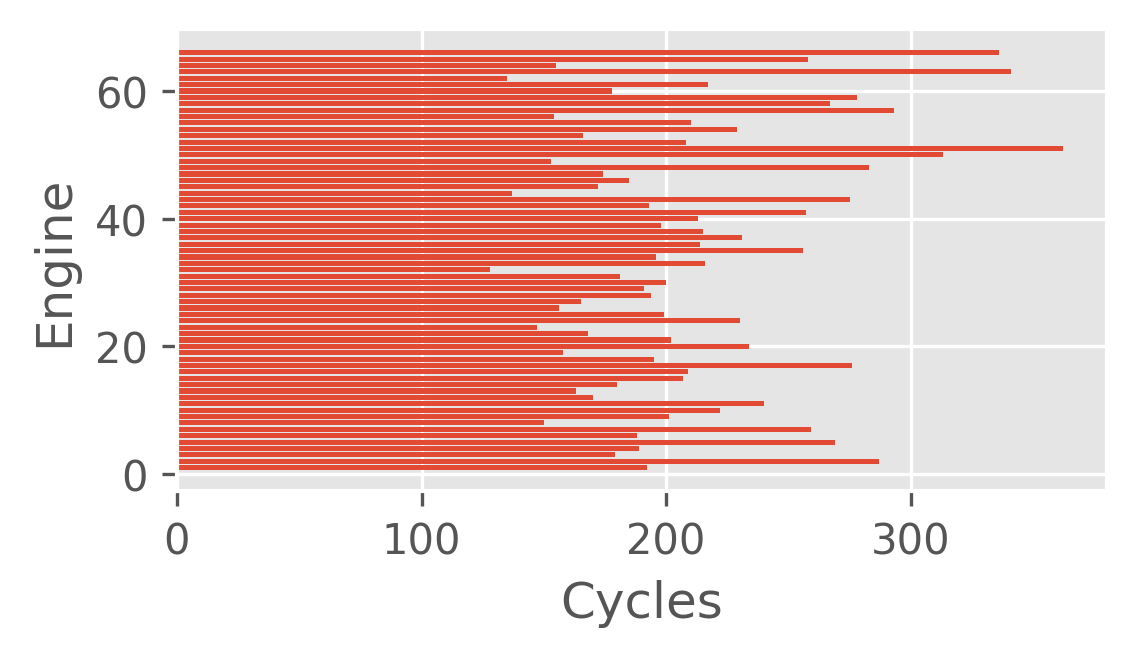

In [10]:
import matplotlib.pyplot as plt

max_cycles_training = max_cycles_training.unique().tolist()

# Set the figure size and dpi
plt.style.use('ggplot')
fig = plt.figure(figsize=(4, 2), dpi=300)

# Create horizontal bar chart
plt.barh(list(range(1, len(max_cycles_training)+1)), max_cycles_training)

# Add x-label and y-label
plt.xlabel('Cycles')
plt.ylabel('Engine')

In [11]:
# Creating a binary column called 'Failure Indicator' that indicated whether an engine will fail within 30 cycles or less
failure_indicator = (train_data['Remaining Useful Life'] <= 30).astype(int)
train_data.insert(loc=train_data.columns.get_loc('Remaining Useful Life') + 1, column='Failure Indicator', value=failure_indicator)

train_data[['id','cycle','Remaining Useful Life','Failure Indicator']].head()

,id,cycle,Remaining Useful Life,Failure Indicator
0,1,1,191,0
1,1,2,190,0
2,1,3,189,0
3,1,4,188,0
4,1,5,187,0


## Scaling the data

This is done to have a better visualization for Box-Plots, without changing the distribution of the data

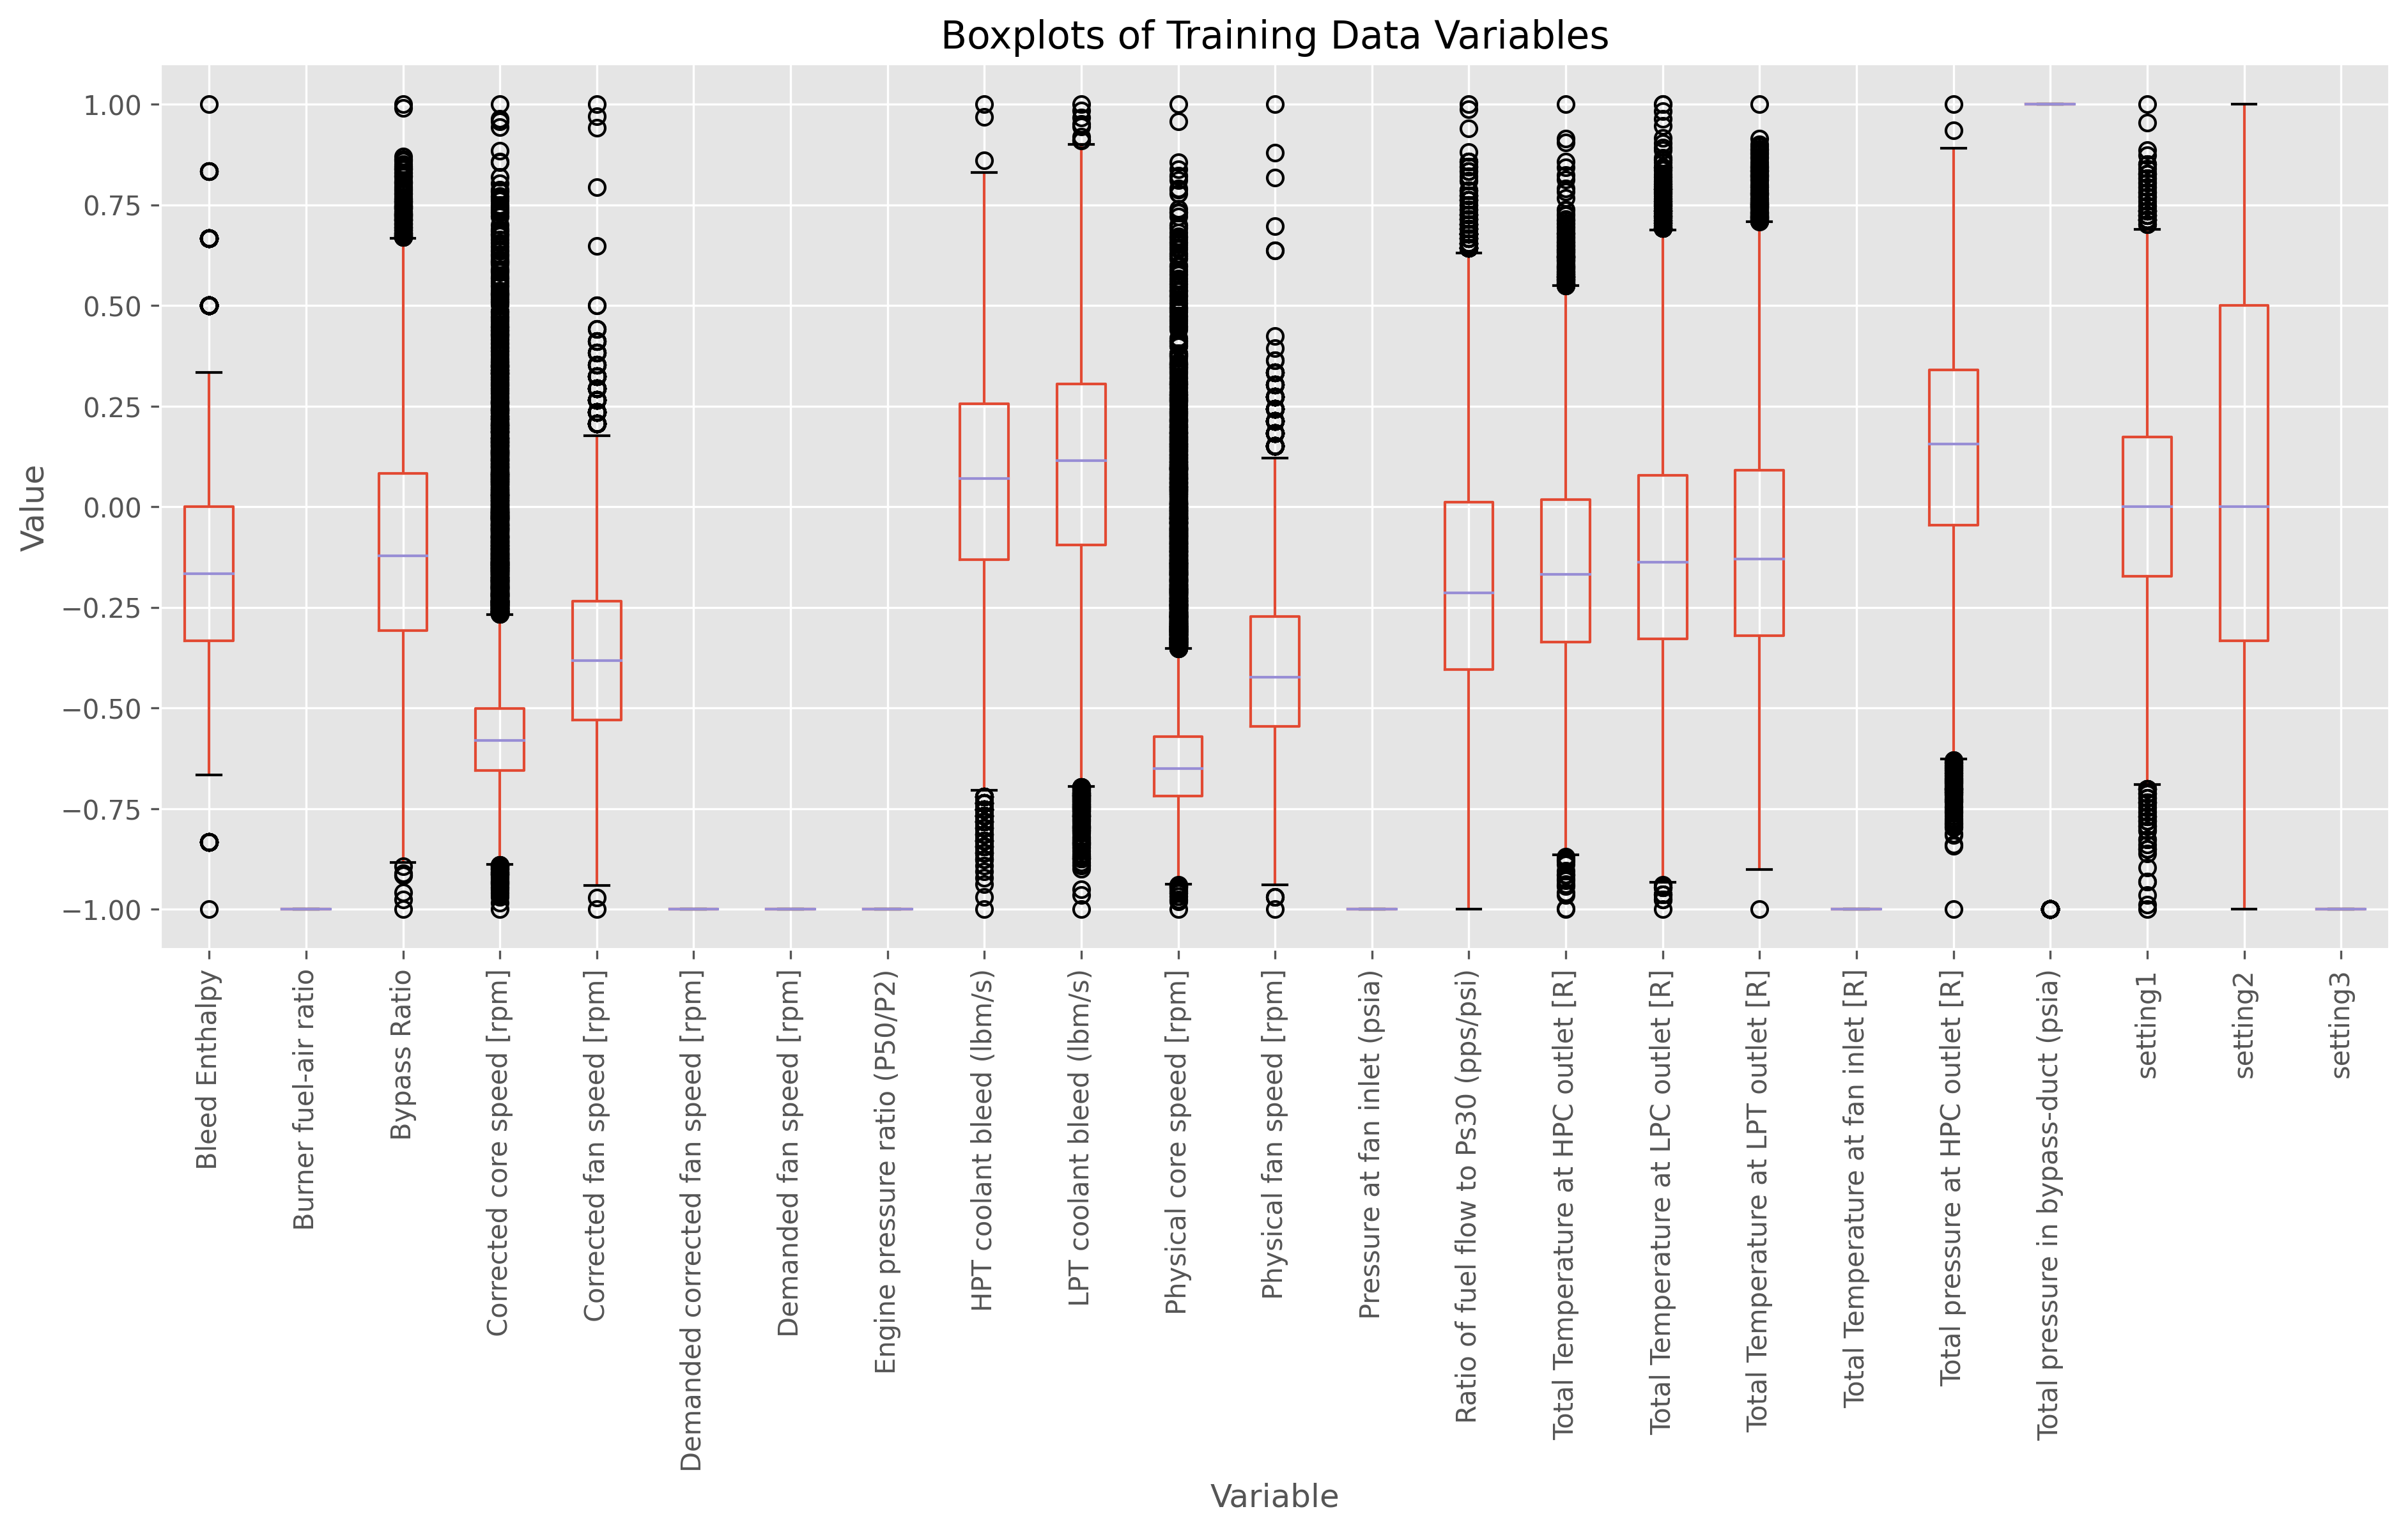

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# List of columns to scale
cols_scaled = train_data.columns.difference(['id','cycle','Remaining Useful Life','Failure Indicator']).to_list()
# fit and transform the data
train_scaled = scaler.fit_transform(train_data[cols_scaled])
# # Convert the scaled numpy array to a pandas DataFrame
train_scaled = pd.DataFrame(train_scaled,columns=cols_scaled)

# Create boxplot
fig, ax = plt.subplots(figsize=(15, 6),dpi=300)
train_scaled.boxplot(ax=ax)

# Set axis labels and title
ax.set_xlabel('Variable')
ax.set_ylabel('Value')
ax.set_title('Boxplots of Training Data Variables')

# Rotate x-axis labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Since I do not have domain specific knowledge to asses the meaning of the outliers, I will keep them

In [13]:
#Join the normalized and non-normalized data.
train_scaled = train_data[['id','cycle','Remaining Useful Life','Failure Indicator']].join(train_scaled)
train_scaled = train_scaled.reindex(columns = train_data.columns)
train_data.head()

,id,cycle,Remaining Useful Life,Failure Indicator,setting1,setting2,setting3,Total Temperature at fan inlet [R],Total Temperature at LPC outlet [R],Total Temperature at HPC outlet [R],...,Ratio of fuel flow to Ps30 (pps/psi),Corrected fan speed [rpm],Corrected core speed [rpm],Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed [rpm],Demanded corrected fan speed [rpm],HPT coolant bleed (lbm/s),LPT coolant bleed (lbm/s)
0,1,1,191,0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,...,47.47,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,190,0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,...,47.49,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,189,0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,...,47.27,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,188,0,0.0007,0.0000,100.0,518.67,642.35,1582.79,...,47.13,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,187,0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,...,47.28,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Scaling Test Data

In [14]:
# fit and transform the data
test_scaled = scaler.fit_transform(test_data[cols_scaled])
# Convert the scaled numpy array to a pandas DataFrame
test_scaled = pd.DataFrame(test_scaled,columns=cols_scaled)

In [15]:
test_data.head()

,id,cycle,setting1,setting2,setting3,Total Temperature at fan inlet [R],Total Temperature at LPC outlet [R],Total Temperature at HPC outlet [R],Total Temperature at LPT outlet [R],Pressure at fan inlet (psia),...,Ratio of fuel flow to Ps30 (pps/psi),Corrected fan speed [rpm],Corrected core speed [rpm],Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed [rpm],Demanded corrected fan speed [rpm],HPT coolant bleed (lbm/s),LPT coolant bleed (lbm/s)
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,47.20,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,47.50,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,47.50,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,47.28,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,47.31,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130


In [16]:
test_scaled.columns

Index(['Bleed Enthalpy', 'Burner fuel-air ratio', 'Bypass Ratio',
       'Corrected core speed [rpm]', 'Corrected fan speed [rpm]',
       'Demanded corrected fan speed [rpm]', 'Demanded fan speed [rpm]',
       'Engine pressure ratio (P50/P2)', 'HPT coolant bleed (lbm/s)',
       'LPT coolant bleed (lbm/s)', 'Physical core speed [rpm]',
       'Physical fan speed [rpm]', 'Pressure at fan inlet (psia)',
       'Ratio of fuel flow to Ps30 (pps/psi)',
       'Total Temperature at HPC outlet [R]',
       'Total Temperature at LPC outlet [R]',
       'Total Temperature at LPT outlet [R]',
       'Total Temperature at fan inlet [R]',
       'Total pressure at HPC outlet [R]',
       'Total pressure in bypass-duct (psia)', 'setting1', 'setting2',
       'setting3'],
      dtype='object')

In [17]:
test_scaled = test_data[['id','cycle']].join(test_scaled)
test_scaled = test_scaled.reindex(columns = test_data.columns)
test_scaled.head()

,id,cycle,setting1,setting2,setting3,Total Temperature at fan inlet [R],Total Temperature at LPC outlet [R],Total Temperature at HPC outlet [R],Total Temperature at LPT outlet [R],Pressure at fan inlet (psia),...,Ratio of fuel flow to Ps30 (pps/psi),Corrected fan speed [rpm],Corrected core speed [rpm],Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed [rpm],Demanded corrected fan speed [rpm],HPT coolant bleed (lbm/s),LPT coolant bleed (lbm/s)
0,1,1,0.3125,0.384615,-1.0,-1.0,0.192429,-0.156063,-0.435573,1.0,...,-0.452055,-0.348837,-0.688954,-0.305849,-1.0,-0.25,-1.0,-1.0,0.000000,0.240198
1,1,2,-0.3125,-0.538462,-1.0,-1.0,-0.634069,0.008050,-0.549520,1.0,...,-0.041096,-0.209302,-0.432272,-0.544583,-1.0,0.00,-1.0,-1.0,0.290909,0.291437
2,1,3,0.0625,0.076923,-1.0,-1.0,-0.160883,-0.070371,-0.307739,1.0,...,-0.041096,-0.348837,-0.605947,0.067114,-1.0,0.00,-1.0,-1.0,0.400000,0.362208
3,1,4,0.5500,-0.076923,-1.0,-1.0,-0.173502,-0.216827,-0.100265,1.0,...,-0.342466,-0.255814,-0.554866,-0.435283,-1.0,-0.50,-1.0,-1.0,0.254545,0.240764
4,1,5,0.2000,-0.076923,-1.0,-1.0,-0.129338,-0.057388,-0.284051,1.0,...,-0.301370,-0.348837,-0.616163,-0.325983,-1.0,-0.75,-1.0,-1.0,0.236364,0.352017


Using the true_test dataset, we will create an additional column which holds the true value of the max cycles in the test dataset

In [18]:
# Group by 'id' and find the max 'cycle' for each group while keeping the same index, for the test data which alone is truncated with an error found in true_test 
max_cycles_test = pd.DataFrame(test_scaled.groupby('id')['cycle'].max()).reset_index()
max_cycles_test.columns = ['id', 'max']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
true_test['id'] = true_test.index + 1
true_test = true_test[['id','Additional RUL']]

true_test['max'] = max_cycles_test['max'] + true_test['Additional RUL']
true_test.head()

,id,Additional RUL,max
0,1,112,143.0
1,2,98,147.0
2,3,69,195.0
3,4,82,188.0
4,5,91,189.0


Adding the corrected max cycle values to the testing dataset

In [19]:
test_scaled = test_scaled.merge(true_test,how='left',on=['id'])
test_scaled['Remaining Useful Life'] = test_scaled['max'] - test_scaled['cycle']
test_scaled['Failure Indicator'] = np.where(test_scaled['Remaining Useful Life']<30,1,0)
test_scaled.head()

,id,cycle,setting1,setting2,setting3,Total Temperature at fan inlet [R],Total Temperature at LPC outlet [R],Total Temperature at HPC outlet [R],Total Temperature at LPT outlet [R],Pressure at fan inlet (psia),...,Burner fuel-air ratio,Bleed Enthalpy,Demanded fan speed [rpm],Demanded corrected fan speed [rpm],HPT coolant bleed (lbm/s),LPT coolant bleed (lbm/s),Additional RUL,max,Remaining Useful Life,Failure Indicator
0,1,1,0.3125,0.384615,-1.0,-1.0,0.192429,-0.156063,-0.435573,1.0,...,-1.0,-0.25,-1.0,-1.0,0.000000,0.240198,112,143.0,142.0,0
1,1,2,-0.3125,-0.538462,-1.0,-1.0,-0.634069,0.008050,-0.549520,1.0,...,-1.0,0.00,-1.0,-1.0,0.290909,0.291437,112,143.0,141.0,0
2,1,3,0.0625,0.076923,-1.0,-1.0,-0.160883,-0.070371,-0.307739,1.0,...,-1.0,0.00,-1.0,-1.0,0.400000,0.362208,112,143.0,140.0,0
3,1,4,0.5500,-0.076923,-1.0,-1.0,-0.173502,-0.216827,-0.100265,1.0,...,-1.0,-0.50,-1.0,-1.0,0.254545,0.240764,112,143.0,139.0,0
4,1,5,0.2000,-0.076923,-1.0,-1.0,-0.129338,-0.057388,-0.284051,1.0,...,-1.0,-0.75,-1.0,-1.0,0.236364,0.352017,112,143.0,138.0,0


## Exploratory Data Analysis

Checking how the sensor values change with time, for a random engine (id)

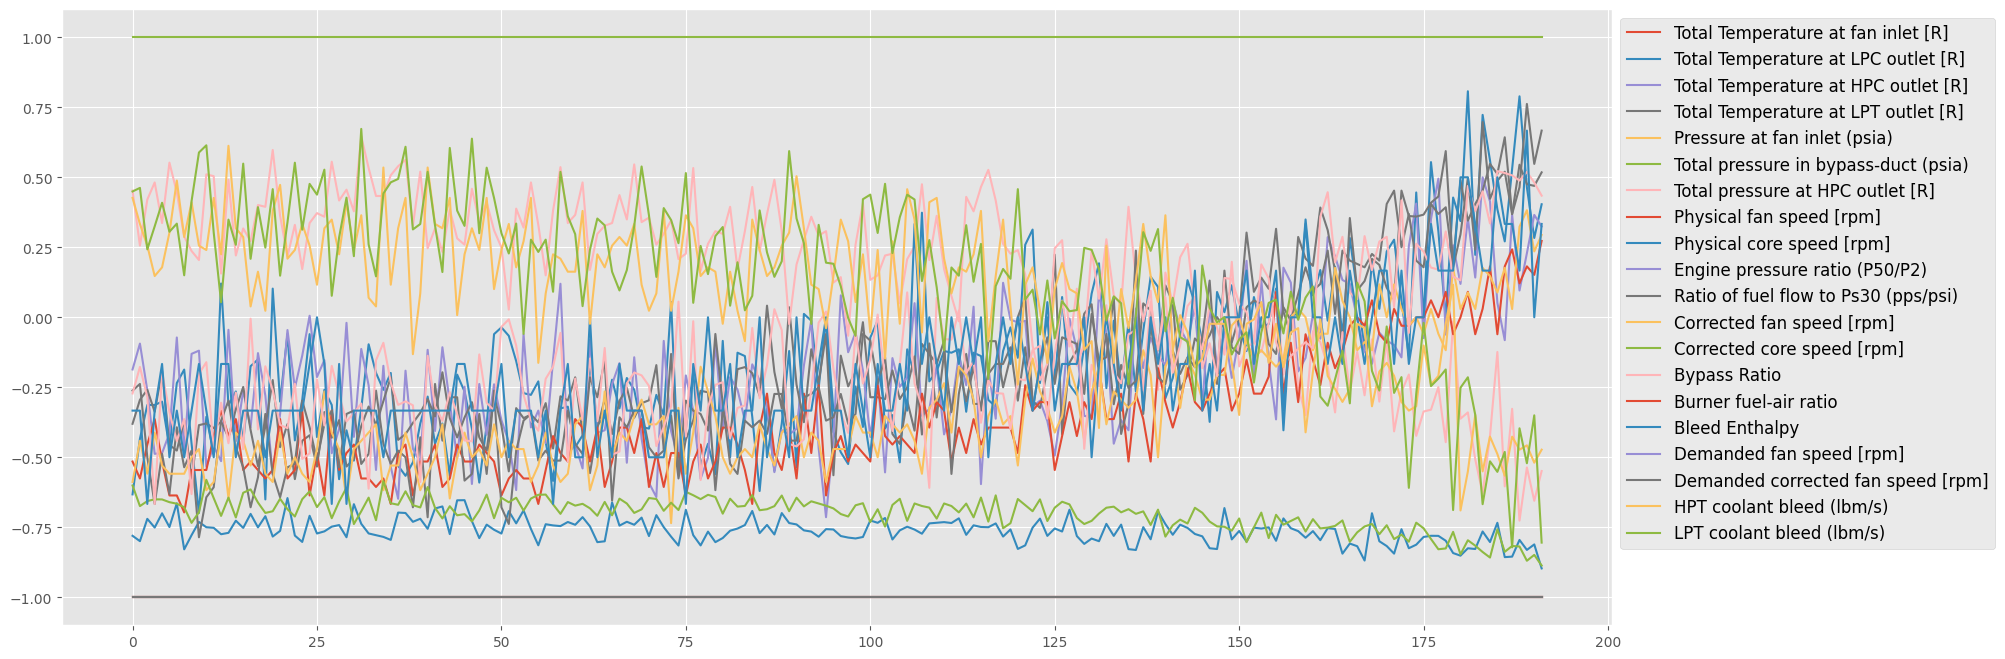

In [20]:
ax = train_scaled[train_scaled.id==1][columns[5:]].plot(figsize=(20, 8))
ax.legend(fontsize=12, bbox_to_anchor=(1, 1), ncol=1)

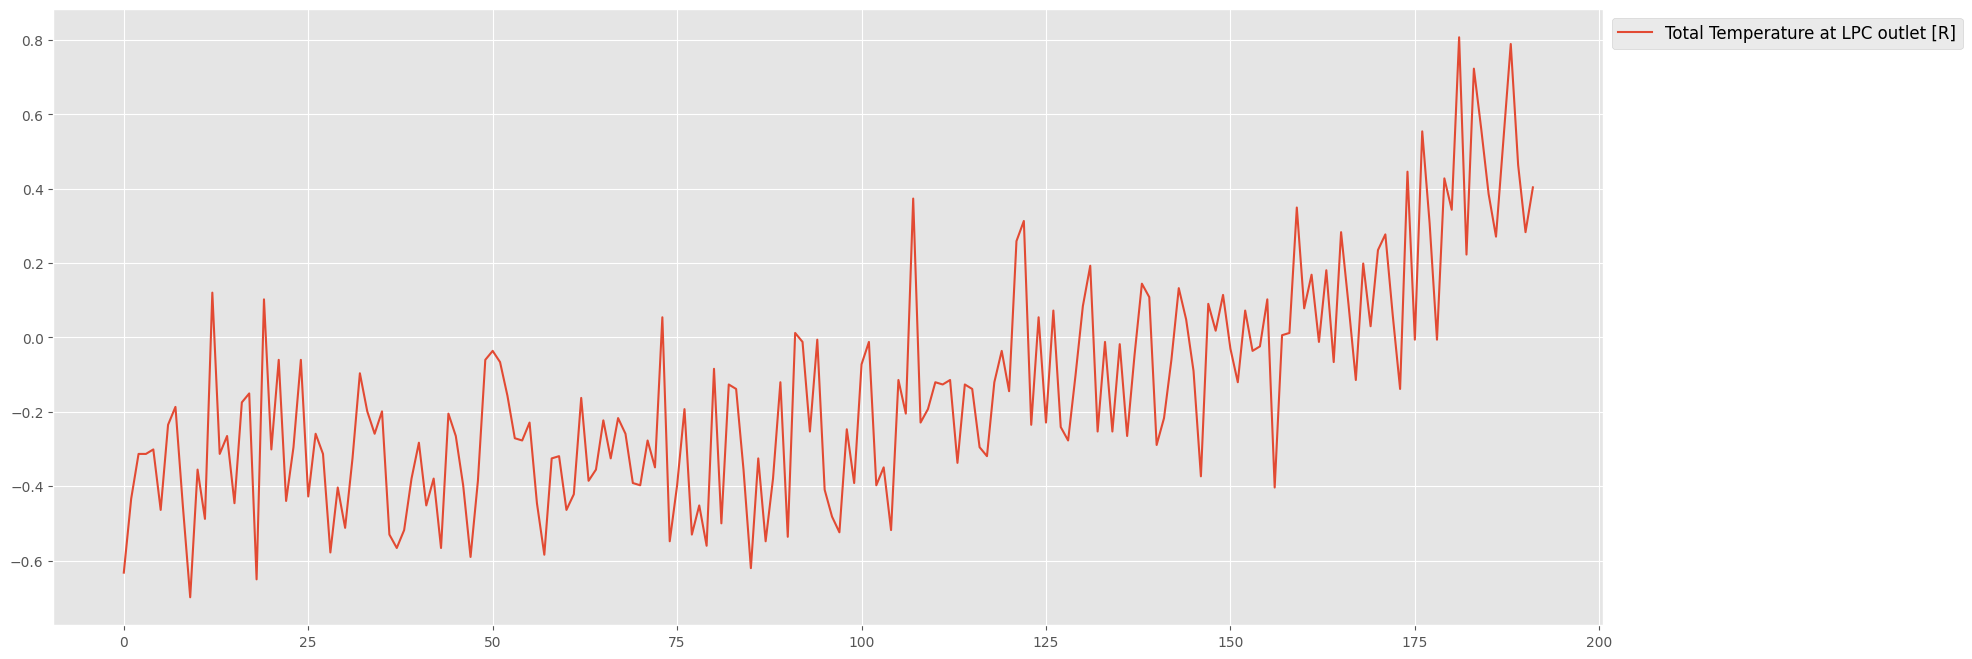

In [21]:
ax = train_scaled[train_scaled.id==1][columns[6]].plot(figsize=(20, 8))
ax.legend(fontsize=12, bbox_to_anchor=(1, 1), ncol=1)

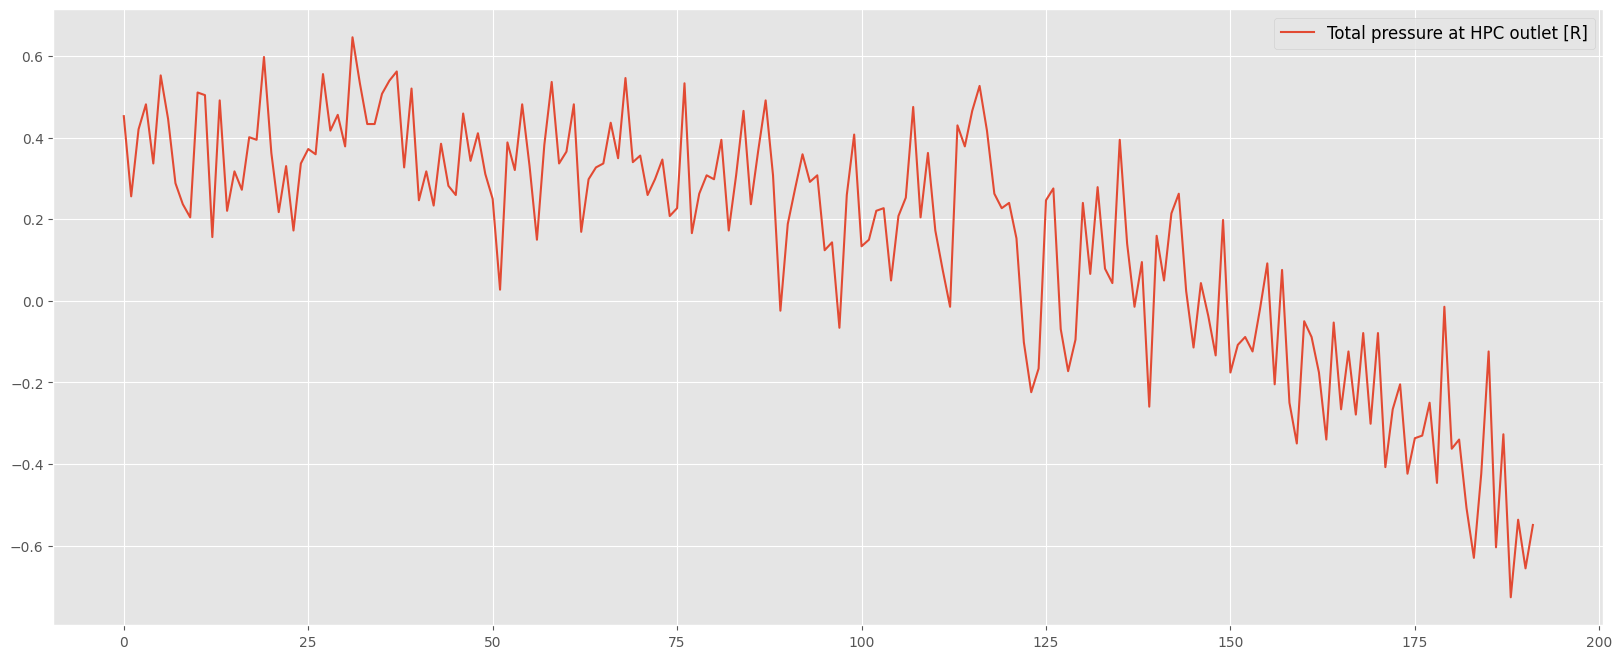

In [22]:
ax = train_scaled[train_scaled.id==1][columns[11]].plot(figsize=(20, 8))
ax.legend(fontsize=12, bbox_to_anchor=(1, 1), ncol=1)

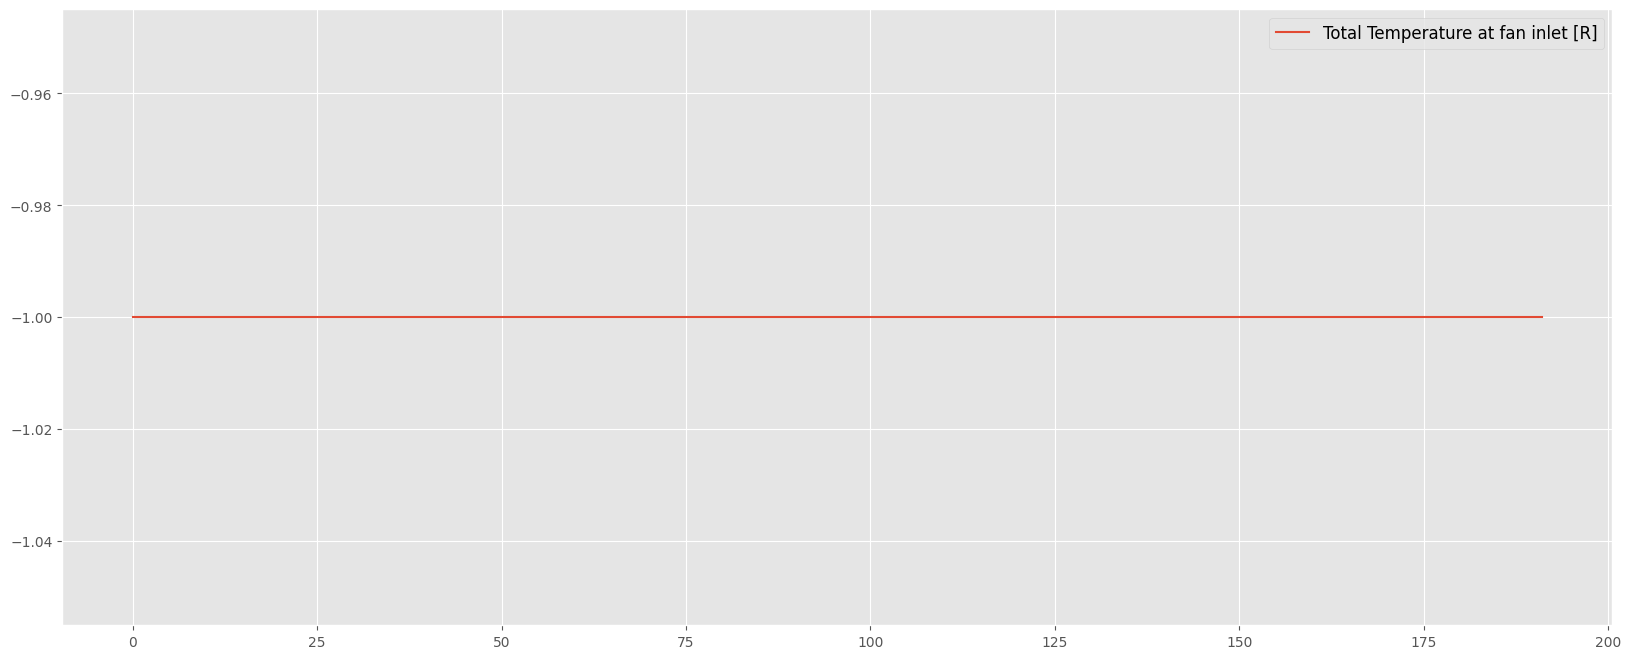

In [23]:
ax = train_scaled[train_scaled.id==1][columns[5]].plot(figsize=(20, 8))
ax.legend(fontsize=12, bbox_to_anchor=(1, 1), ncol=1)

## Key takeaways

- Most sensor values exhibit either an increasing or decreasing trend over cycles
- Some sensors have constant values

Text(0.5, 1.0, 'Total Temperature at LPC outlet for Each ID')

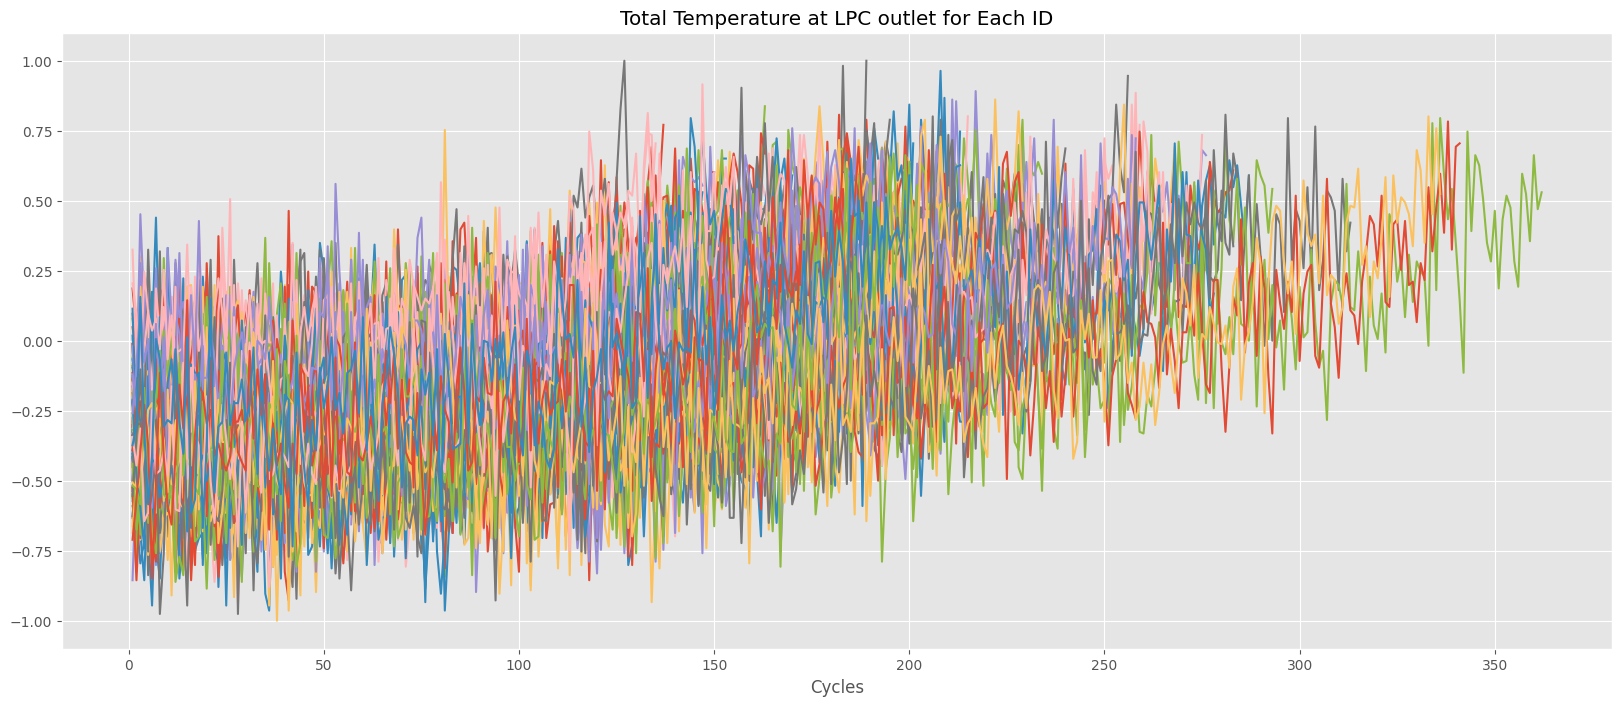

In [24]:
# Get the maximum id value
max_id = train_scaled['id'].max()

# Set the plot size
fig, ax = plt.subplots(figsize=(20, 8))

# Loop over each id value and plot the specified column
for i in range(1, max_id+1):
    # Filter the data for the current id value
    data = train_scaled[train_scaled['id'] == i]
    
    # Plot the specified column for the current id value
    ax.plot(data[columns[1]], data[columns[6]], label=f'id={i}')

# Set the axis labels and title
ax.set_xlabel('Cycles')
ax.set_title('Total Temperature at LPC outlet for Each ID')

Text(0.5, 1.0, 'Total pressure at HPC outlet')

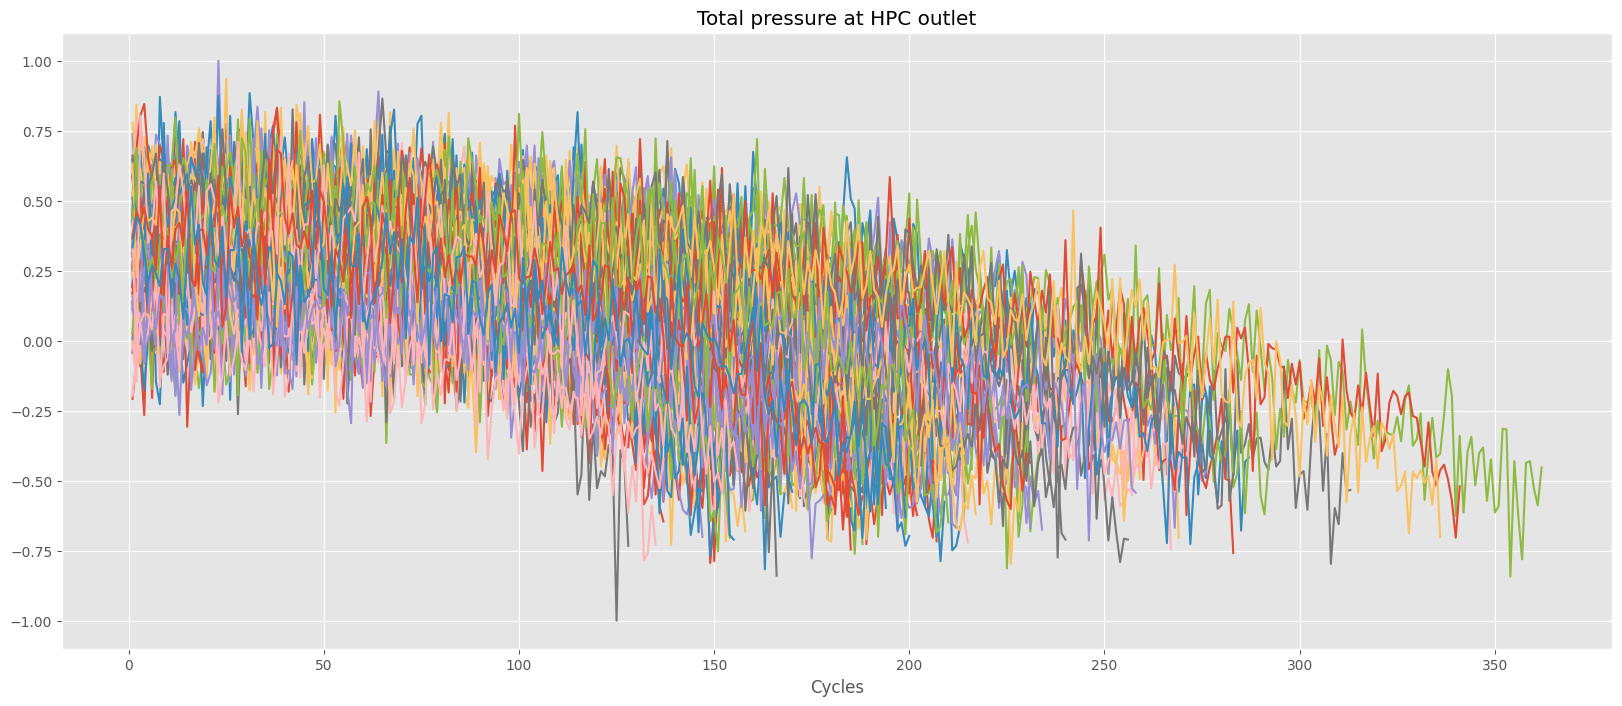

In [25]:
# Set the plot size
fig, ax = plt.subplots(figsize=(20, 8))

# Loop over each id value and plot the specified column
for i in range(1, max_id+1):
    # Filter the data for the current id value
    data = train_scaled[train_scaled['id'] == i]
    
    # Plot the specified column for the current id value
    ax.plot(data[columns[1]], data[columns[11]], label=f'id={i}')

# Set the axis labels and title
ax.set_xlabel('Cycles')
ax.set_title('Total pressure at HPC outlet')

Here I have plotted just 2 sensor observations for all training engines.

All observations for each sensor has consistent behavior, and we can see that when the values approach a certain value the engine might fail soon. 

## Checking for NaNs

In [26]:
# Check for NaNs in the training data
nan_cols = train_scaled.columns[train_scaled.isna().any()].tolist()
print(train_scaled[nan_cols].isna().sum())

Series([], dtype: float64)


In [27]:
# Check for NaNs in the training data
nan_cols = test_scaled.columns[test_scaled.isna().any()].tolist()
print(test_scaled[nan_cols].isna().sum())

Total pressure in bypass-duct (psia)    1
Total pressure at HPC outlet [R]        1
Physical fan speed [rpm]                1
Physical core speed [rpm]               1
Engine pressure ratio (P50/P2)          1
Ratio of fuel flow to Ps30 (pps/psi)    1
Corrected fan speed [rpm]               1
Corrected core speed [rpm]              1
Bypass Ratio                            1
Burner fuel-air ratio                   1
Bleed Enthalpy                          1
Demanded fan speed [rpm]                1
Demanded corrected fan speed [rpm]      1
HPT coolant bleed (lbm/s)               1
LPT coolant bleed (lbm/s)               1
dtype: int64


In [28]:
# Drop rows with NaNs in the training data
test_scaled = test_scaled.dropna()

# Check again for NaNs
nan_cols = test_scaled.columns[test_scaled.isna().any()].tolist()
print(test_scaled[nan_cols].isna().sum())

Series([], dtype: float64)


## Decision Tree Classification

Accuracy: 0.947227


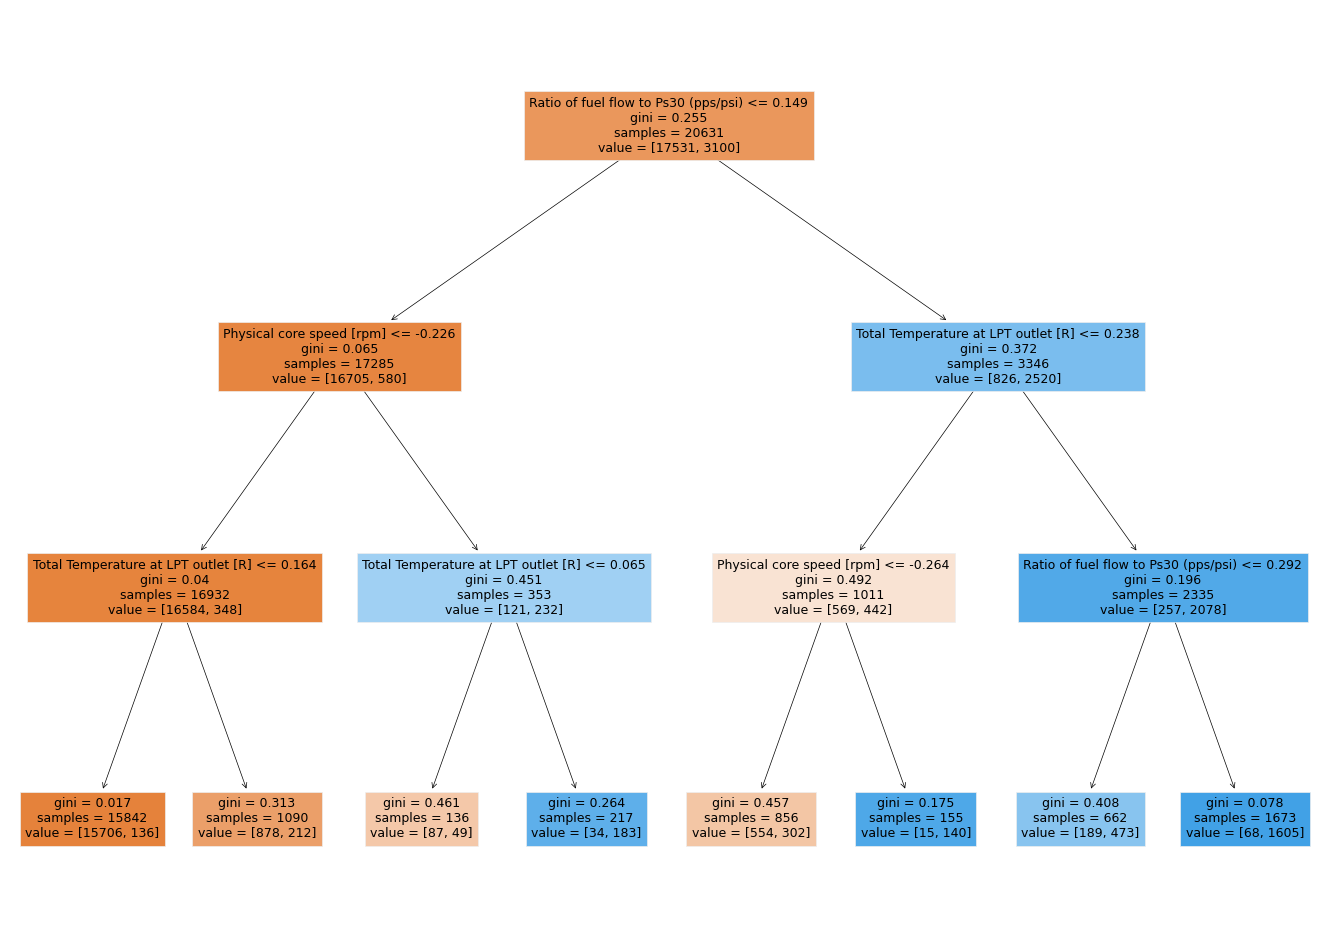

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

# Assuming your data is in pandas DataFrames: train_df for training data and test_df for testing data
X_train = train_scaled.drop(['id', 'cycle', 'Remaining Useful Life', 'Failure Indicator'], axis=1)
y_train = train_scaled['Failure Indicator']

X_test = test_scaled.drop(['id', 'cycle', 'Remaining Useful Life', 'Failure Indicator','Additional RUL', 'max'], axis=1)
y_test = test_scaled['Failure Indicator']

# Create and train the decision tree
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

# Use the tree to make predictions on the test set
y_pred = model.predict(X_test)

# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % (accuracy))
plt.figure(figsize=(17,12))
tree.plot_tree(model, filled=True, feature_names=X_train.columns, fontsize=9)
plt.show()

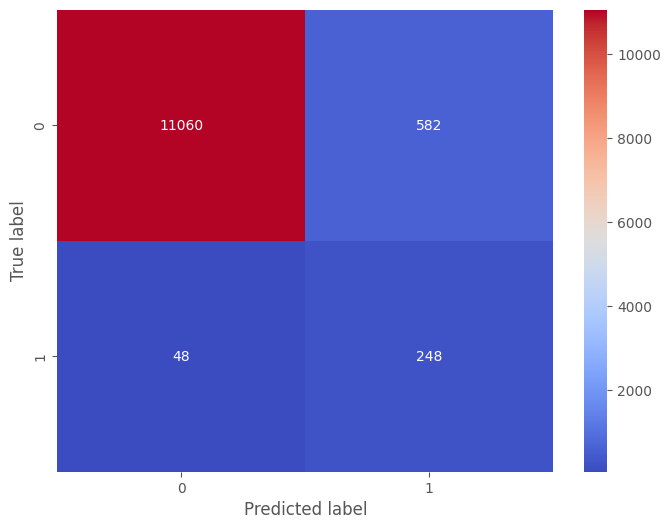

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model Summary:
- Accuracy: 94.7
- If Predicted no maintenace required: 99.5% chance we won't need to perform maintenace
- If Predicted mainteance required: 30% chance we have to perform maintenance